## Analysis of the method with simulations and with the Universitat Jaume data

 


### Simulation

In [4]:
#initializations
import numpy as np
init_timestamp = 1436047260000 
beta = (60/55)*60*1000 # in ms, according to the paper Freudiger 2015, mean time delay between packets
sigma_est = 3 # the average gaussian error of the optimization by multilateration
half_dist_teleport =10 # half of the distance between two twin points
sigma_teleport = 3 # the average displacement of the twin from the firsty generated position
measurement_delay = 1000 # in ms , delay between two measurements in the original positions
randomized_probability = 0.15 # the probability that a mac address is randomized
path_original_positions = "F:/Arena_sim_data/original_positions1_size_" # here are written the original positions (ground truth)
path_fake_positions = "F:/Arena_sim_data/fake_positions1_size_" # here come the simulated positions after introducing uncertainties
filepath_method_output = "F:/Arena_sim_data/output/size_" # after applying the method, here resides the output of it

In [6]:
# for all persons generates (simulates) the first moment they were detected
def generate_first_moment_visible(crowd_size): #initialization      
    next_moment =[]
    for i in range(0, crowd_size):
        delay = np.random.exponential(beta)
        next_moment.append(int(init_timestamp  + delay))    
    return next_moment    

In [7]:
#test
next_moment = generate_first_moment_visible(3)
next_moment

[1436047415852, 1436047373595, 1436047298367]

In [8]:
# given a timestamp, generates the next moment for a particular device to be detected
def gen_next_moment(timestamp_now): # next moment is drawn from exponential(1/beta) distribution
    delay = np.random.exponential(beta)+1# avoid 0
    return int(timestamp_now + delay)

In [9]:
#test
next_mom = gen_next_moment(3)

In [10]:
# makes a new record in the format of the json file that is output of Arena multilateration and input to the density estimation method
def make_new_record(record, new_position, randomized):#record = [timestamp, personId, x, y], new_position = [x,y]
    sigma_x =  np.random.exponential(sigma_est)
    sigma_y =  np.random.exponential(sigma_est)
    new_record = {}
    new_record["measurementTimestamp"] = record[0]
    new_record["value"] = {}
    new_record["value"]["sourceMac"] = record[1]
    new_record["value"]["averagecoordinate"] = {}
    new_record["value"]["averagecoordinate"]["avg"] = {}
    new_record["value"]["averagecoordinate"]["avg"]["coordinates"] =[new_position[0], new_position[1], 0.0]
    new_record["value"]["averagecoordinate"]["error"] = {}
    new_record["value"]["averagecoordinate"]["error"]["coordinates"] = [sigma_x, sigma_y, 1000.0]#in the real data for z is 1000
    new_record["value"]["trackeeHistory"]={}
    new_record["value"]["trackeeHistory"]["localMac"] = randomized
    return new_record

In [11]:
#test
b = make_new_record([0,1,3,4], [5,6], 0)

In [12]:
b

{'measurementTimestamp': 0,
 'value': {'averagecoordinate': {'avg': {'coordinates': [5, 6, 0.0]},
   'error': {'coordinates': [1.084072779453603, 0.3101160367054786, 1000.0]}},
  'sourceMac': 1,
  'trackeeHistory': {'localMac': 0}}}

In [13]:
# returns a list denoting for every mac adress if it has been randomized or not
def generate_randomized(crowd_size):
    randomized = [0 for i in range(0, crowd_size)]
    for i in range(0, crowd_size):
        r = np.random.rand()
        if r < randomized_probability:
            randomized[i] = 1
    return randomized

In [14]:
#test
randomized = generate_randomized(10)

In [15]:
randomized


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [16]:
# given a position x, generates a new coordinate x' according to the twins distribution
def draw_new_coordinate(position, modes_half_distance=10.0, sigma=5.0):
    rand_mode = np.random.rand()
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    mu = position + rand_mode*modes_half_distance
    new_pos = np.random.normal(mu, sigma)
    return new_pos
    

In [17]:
draw_new_coordinate(2, 10, 3)

-12.769962045764656

In [18]:
# given a location (x, y) in record = [timestamp, address, x,  y], draws a new location (x',y') according to the twins distribution
def create_teleportation_effect_single(record, modes_half_distance, sigma):            
        record_x = draw_new_coordinate(record[2], modes_half_distance, sigma)
        record_y = draw_new_coordinate(record[3], modes_half_distance, sigma)
        return [record_x, record_y]

In [19]:
# given a list of positions and the size of the crowd, simulates new data that includes the uncertainties
def make_fake_data(crowd_size, positions):
    json = {}
    timestamp = init_timestamp    
    next_moment = generate_first_moment_visible(crowd_size)
    randomized = generate_randomized(crowd_size)
    fake_positions = []
    for record in positions: #record = [timestamp, personId, x, y]
        person = record[1]        
        timestamp = record[0]
        if next_moment[person] > timestamp-measurement_delay and next_moment[person] <= timestamp:#timestamp
                new_position = create_teleportation_effect_single(record, half_dist_teleport, sigma_teleport)#[x,y]
                fake_record = make_new_record(record, new_position, randomized[person])
                fake_positions.append(fake_record)                
                next_moment[person] = gen_next_moment(next_moment[person])
    return fake_positions            

In [20]:
# given a list of positions and the size of the crowd, simulates new data that includes the space uncertainties FOR EVERY MEASURMENT TIMESTAMP
def make_fake_data1(crowd_size, positions):
    json = {}
    timestamp = init_timestamp    
    fake_positions = []
    for record in positions: #record = [timestamp, personId, x, y]
        person = record[1]        
        timestamp = record[0]        
        new_position = create_teleportation_effect_single(record, half_dist_teleport, sigma_teleport)#[x,y]
        fake_record = make_new_record(record, new_position,0)
        fake_positions.append(fake_record)                        
    return fake_positions   

In [21]:
# given density of the crowd, returns the maximal velocity that a person can have by Weidmann's equation
def get_max_velocity(crowd_density):#by Weidmann's equation
    rho = crowd_density+0.00001 #avoid division by 0
    v_0=1.34 #speed at 0 density
    gamma = 1.913 #fit parameter
    rho_max = 5.4 #at this density movement is not possible
    v =v_0*(1-np.exp(-gamma*(1/rho-1/rho_max)))
    v = max(0, v)
    return v

In [22]:
# a function that generates a random number in {-1,1}
def gen_rand_mode():
    rand_mode = np.random.rand() 
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    return rand_mode

In [171]:
# creates the original (ground truth) positions of the crowd assuming random motion (close to Brownian, 4 directions). The velocity depends on the crowd density
from scipy.stats import norm
def create_positions(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium):
    positions = []    
    i = 0
    dt = measurement_delay/1000#from ms to s
    density = crowd_size/(width_stadium*length_stadium)#should be the local ideally
    velocity = get_max_velocity(density)
    delta =velocity*dt  #for the brownian motion, how many meters per dt:    
    for person in range(0, crowd_size):#initialize randomly
            positions.append([init_timestamp, person, (np.random.rand() -0.5)*width_stadium, (np.random.rand() -0.5)* length_stadium])
    for timestamp in range(measurement_delay, time_interval, measurement_delay):
        for person in range(0, crowd_size):
            old_position = positions[i-crowd_size]
            old_x = old_position[2]
            old_y = old_position[3]
            #new_x = old_x + norm.rvs(scale=delta**2*dt) # this is very slow as it uses inverse functions
            #new_y = old_y + norm.rvs(scale=delta**2*dt)
            rand_mode = gen_rand_mode()
            new_x = old_x + delta*rand_mode    
            rand_mode = gen_rand_mode()            
            new_y = old_y + delta*rand_mode
            if (abs(new_x) < width_stadium*0.5 and abs(new_y) < length_stadium*0.5):
                positions.append([init_timestamp+ timestamp, person, new_x, new_y])    
            else:
                positions.append([init_timestamp+ timestamp, person, old_x, old_y])
            i+=1
    return positions 

In [173]:
# creates the original (ground truth) positions of a static crowd, inerval is in seconds, stadium size in meters
from scipy.stats import norm
def create_positions1(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium):
    positions = []     
    i = 0
    for person in range(0, crowd_size):#initialize randomly
            positions.append([init_timestamp, person, (np.random.rand() -0.5)*width_stadium, (np.random.rand() -0.5)* length_stadium])
    for timestamp in range(measurement_delay, time_interval, measurement_delay):
        for person in range(0, crowd_size):
            old_position = positions[i-crowd_size]
            old_x = old_position[2]
            old_y = old_position[3]
            positions.append([init_timestamp+ timestamp, person, old_x, old_y])
            i+=1
    return positions 

In [25]:
import json

def write_fake_positions(positions,filename):
    file = open(filename, 'w')
    file.close()
    with open(filename, 'a') as outfile:
        for record in positions:
            json.dump(record, outfile)  
            outfile.write("\n")
        

In [26]:
import pickle

def write_original_positions(positions, filepath):   
    with open(filepath, 'wb') as fp:
        pickle.dump(positions, fp)

In [27]:

def read_original_positions( filepath):   
    with open(filepath, 'rb') as fp:
        positions = pickle.load(fp)
    return positions    

In [28]:
def makedata(crowd_size, step, howmany):#howmany is the numbero of iterations crowd_size is the initial size, step is the increase of the size in every iteration
    #crowd_size = 65000
    #step = 5000
    for i in range(0, howmany):
        crowd_size = crowd_size + step     
        print(crowd_size)
        positions = create_positions(init_timestamp, crowd_size, 300*1000 , 105, 68)#300 sec
        write_original_positions(positions, path_original_positions + str(crowd_size)+".pkl")
        fake_positions = make_fake_data(crowd_size, positions)
        write_fake_positions(fake_positions, path_fake_positions + str(crowd_size)+".json")        

In [ ]:
#makes data for a static crowd by only introducing teleportation effect( space uncertainties), no packet delay, no randomization
def makedata1(crowd_size, step, howmany):
    #crowd_size = 65000
    #step = 5000
    for i in range(0, howmany):
        crowd_size = crowd_size + step     
        print(crowd_size)
        positions = create_positions1(init_timestamp, crowd_size, 10*1000 , 105, 68)#10 sec
        write_original_positions(positions, path_original_positions + str(crowd_size)+".pkl")
        fake_positions = make_fake_data1(crowd_size, positions)
        write_fake_positions(fake_positions, path_fake_positions + str(crowd_size)+".json")   

In [98]:
# gets a snapshot of the crowd detected at time [timestamp, timestamp + interval),  interval is in seconds
def get_a_snapshot(positions,  timestamp, interval, memory=0):    
    snapshot = []        
    counted = {}
    for position in positions:
        if position[0] >= timestamp-memory*interval*1000 and position[0] <= timestamp + interval*1000:
            if position[1] not in counted:
                snapshot.append(position)
                counted[position[1]] = True                
    return snapshot        

In [229]:
# returns the number of people in the given box, first filters positions by time and then by space.
def get_crowd_count_in_square_old(timestamp, positions, crowd_size, x_center, y_center, half_width_x, half_length_y, interval, memory):
    snapshot = get_a_snapshot(positions,  timestamp, interval, memory)
    crowd_count = 0
    for record in snapshot:
        if record[2] >= x_center - half_width_x and record[2] <= x_center + half_width_x:
            if record[3] >= y_center - half_length_y and record[3] <= y_center + half_length_y:
                crowd_count +=1
    return crowd_count

In [264]:
# returns the number of people in the given box, first filters out positions by space and then by time.
def get_crowd_count_in_square(timestamp, positions, crowd_size, x_center, y_center, half_width_x, half_length_y, interval, memory):
    counted = {}
    crowd_count = 0
    for record in positions:
        if record[1] not in counted:
            if record[2] >= x_center - half_width_x and record[2] <= x_center + half_width_x:
                if record[3] >= y_center - half_length_y and record[3] <= y_center + half_length_y:
                    if record[0] >= timestamp-memory*interval*1000 and record[0] <= timestamp + interval*1000:
                        crowd_count +=1
                        counted[record[1]] = True                    
    return crowd_count

In [31]:
import pickle
def read_original_positions(filepath):
    return pickle.load(open( filepath, "rb" ))

In [32]:
def read_fake_positions(filepath):
    data = []
    with open(filepath) as f:
        data = f.readlines()
    fake_positions = []
    for line in data:
        jsline = json.loads(line)
        fake_positions.append([jsline["measurementTimestamp"], jsline["value"]["sourceMac"], jsline["value"]["averagecoordinate"]["avg"]["coordinates"][0], jsline["value"]["averagecoordinate"]["avg"]["coordinates"][1]])
    return fake_positions

In [34]:
b

{'measurementTimestamp': 0,
 'value': {'averagecoordinate': {'avg': {'coordinates': [5, 6, 0.0]},
   'error': {'coordinates': [1.084072779453603, 0.3101160367054786, 1000.0]}},
  'sourceMac': 1,
  'trackeeHistory': {'localMac': 0}}}

In [261]:
def get_all_cells(filepath,  xmin_cell, xmax_cell, ymin_cell, ymax_cell, timeperiod):
    total =0        
    z_data = np.loadtxt(filepath + 'dens_histo_%d.csv' % timeperiod, delimiter=',')
    for cell_x in range (int(xmin_cell), int(xmax_cell)):
        for cell_y in range (int(ymin_cell), int(ymax_cell)):
            total += z_data[cell_y][cell_x]
    return round(total)   

In [223]:
# this computes the counts of people from the ground truth, the simulated data and from the method applied to the simulated data
# previously the density estimation should be run on the simulated json data
def run( width_stadium, length_stadium, window, stride, crowd_size, step, iterations):
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    cell_start_x = 0
    cell_end_x = 4
    cell_start_y = 0
    cell_end_y = 4
    number_of_cells_x = cell_end_x - cell_start_x  
    number_of_cells_y = cell_end_y - cell_start_y
    x_offset = -width_stadium/2.0
    y_offset = -length_stadium/2.0
    center_x = cell_start_x + number_of_cells_x/2.0 + x_offset
    center_y = cell_start_y + number_of_cells_y/2.0 + y_offset
    cell_size = 1
    for i in range (0, iterations):
        crowd_size +=step
        print(i)
        positions = read_original_positions(path_original_positions + str(crowd_size)+".pkl")
        print(crowd_size)                
        original_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, positions, crowd_size, center_x, center_y, number_of_cells_x*cell_size/2.0, number_of_cells_y*cell_size/2.0, 0, 0) 
        original_proportion = original_crowd_count/crowd_size
        positions = []
        fake_positions = read_fake_positions(path_fake_positions + str(crowd_size) + ".json")
        fake_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, fake_positions, crowd_size, center_x, center_y, number_of_cells_x*cell_size/2.0, number_of_cells_y*cell_size/2.0, 0, 0)
        fake_positions = []
        #method_crowd_count = 1.176*get_all_cells_sim(filepath_method_output,crowd_size, cell_start,cell_end,  cell_start,cell_end, window)# multipied by 1.176 to account of  the randomized adresses       
        method_crowd_count = 1.0*get_all_cells_sim(filepath_method_output+ str(crowd_size) + "_",crowd_size, cell_start_x,cell_end_x,  cell_start_y,cell_end_y, window)# multipied by 1.176 to account of  the randomized adresses       
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [[], [], [], [],original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [ ]:
#makedata1(2500, 10000, 5 )

#### Plotting the results of comparison

In [ ]:
lists_cell2 = run( 105.0, 68.0, 1, 0, 30, 2500, 10000, 5)

In [ ]:
lists_cell2_1 = run( 105.0, 68.0, 1, 8, 30, 2500, 5000, 10)

In [102]:
#merging the even and odd iterations (because first I generated data with step 5000 and then decided to have a step of 2500)
x = np.array([r for r in lists_cell2[4] ])
y = np.array([r for r in lists_cell2[5] ])
z = np.array([r for r in lists_cell2[6] ])
x1 = np.array([r for r in lists_cell2_1[4] ])
y1 = np.array([r for r in lists_cell2_1[5] ])
z1 = np.array([r for r in lists_cell2_1[6] ])
x_total = []
y_total = []
z_total = []
for i in range (0, 10):
    x_total.append(x[i])
    x_total.append(x1[i])
    y_total.append(y[i])
    y_total.append(y1[i])
    z_total.append(z[i])
    z_total.append(z1[i])
#x_total.append(x[10])
#y_total.append(y[10])
#z_total.append(z[10])
   

In [ ]:
lists_cell1 = run( 105.0, 68.0,  0, 30, 2500, 10000, 5)

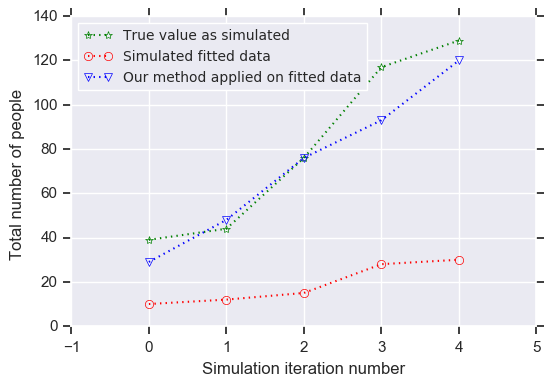

In [228]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

x_total = lists_cell1[4]
y_total = lists_cell1[5]
z_total = lists_cell1[6]

plt.plot(x_total,  linestyle = ":", marker = '*', fillstyle = "none", color = "green", label = "True value as simulated"  )
plt.plot(y_total,  linestyle = ':', marker = "o", fillstyle = "none", color = "red",  label = "Simulated fitted data")
plt.plot(z_total,  linestyle = ":", marker = 'v', fillstyle = "none", color = "blue",  label = "Our method applied on fitted data")

plt.xlabel('Simulation iteration number')
plt.ylabel('Total number of people ')
plt.legend(loc = 2, fontsize  = 10)
plt.grid(True)
axes = plt.gca()
axes.set_xlim([-1, 5])
plt.show()

In [ ]:
##the following graph was obtained with KDE

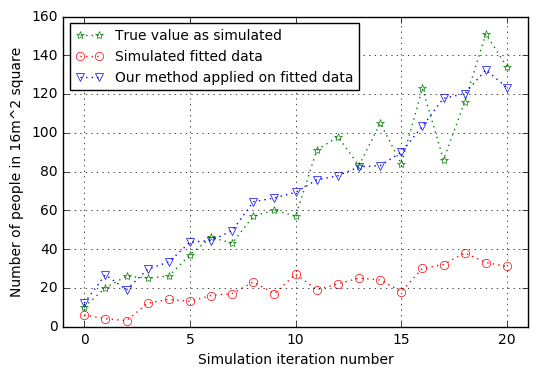

In [752]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np


plt.plot(x_total,  linestyle = ":", marker = '*', fillstyle = "none", color = "green", label = "True value as simulated"  )
plt.plot(y_total,  linestyle = ':', marker = "o", fillstyle = "none", color = "red",  label = "Simulated fitted data")
plt.plot(z_total,  linestyle = ":", marker = 'v', fillstyle = "none", color = "blue",  label = "Our method applied on fitted data")

plt.xlabel('Simulation iteration number')
plt.ylabel('Number of people in 16m^2 square')
plt.legend(loc = 2, fontsize  = 10)
plt.grid(True)
axes = plt.gca()
axes.set_xlim([-1, 21])
plt.show()

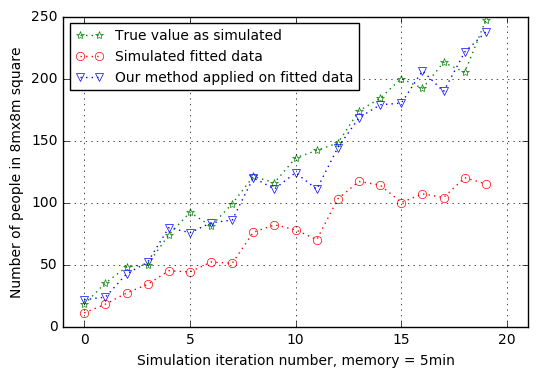

In [71]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np


plt.plot(x_total,  linestyle = ":", marker = '*', fillstyle = "none", color = "green", label = "True value as simulated"  )
plt.plot(y_total,  linestyle = ':', marker = "o", fillstyle = "none", color = "red",  label = "Simulated fitted data")
plt.plot(z_total,  linestyle = ":", marker = 'v', fillstyle = "none", color = "blue",  label = "Our method applied on fitted data")

plt.xlabel('Simulation iteration number, memory = 5min')
plt.ylabel('Number of people in 8mx8m square')
plt.legend(loc = 2, fontsize  = 10)
plt.grid(True)
axes = plt.gca()
axes.set_xlim([-1, 21])
plt.show()

## Fingerprinting data: comparison of results

In [754]:
# makes a json file out of given positions
def make_fingerprint_data(positions):
    json = {}
    timestamp = 0   
    fing_positions = []
    for record in positions: #record = [timestamp, personId, x, y]          
        fing_record = make_new_record(record, [record[2], record[3]], 0)
        fing_record["value"]["averagecoordinate"]["error"]["coordinates"] = [0.01, 0.01, 1000.0]#bogus errors as placeholders since there are no gaussian errors in this dataset
        fing_positions.append(fing_record)                               
    return fing_positions            

#### Creating the json files for input to the density estimation method

Before running this the data needs to be created with the fingerprinting notebook

In [375]:
positions = read_original_positions("F:/ArenaData/Fingerprinting/positions.pkl")
data = make_fingerprint_data(positions) 
write_fake_positions(data,"F:/ArenaData/Fingerprinting/fingerprints_GPS.json")

In [ ]:
positions

In [376]:
positions = read_original_positions("F:/ArenaData/Fingerprinting/positions_fitted.pkl")
data = make_fingerprint_data(positions) 
write_fake_positions(data,"F:/ArenaData/Fingerprinting/fingerprints_fitted.json")

#### Comparing the results

Before running the following analysis the density estimation method has to be applied to the json files

In [252]:
import numpy as np
init_timestamp = 1369908924*1000 + 1804000*1000
measurement_delay = 1000 # in ms
path_original_positions = "F:/ArenaData/Fingerprinting/"
path_fake_positions = "F:/ArenaData/Fingerprinting/"
filepath_output = "F:/Arena_sim_data/output/fingerprinted_method_"

In [271]:
def get_crowd_count_in_square_fing(timestamp, positions, x_min, x_max, y_min, y_max, belt, interval):
    snapshot = get_a_snapshot(positions,  timestamp, interval)
    crowd_count = 0
    for record in snapshot:
        if record[2] > x_min and record[2] < x_max:
            if record[3] > y_min and record[3] < y_max:
                crowd_count +=1
    return crowd_count

In [268]:
def get_crowd_count_in_square_fing_new(timestamp, positions, x_min, x_max, y_min, y_max, belt, interval):
    counted = {}
    crowd_count = 0
    for record in positions:
        if record[1] not in counted:
            if record[2] > x_min and record[2] < x_max:
                if record[3] > y_min and record[3] < y_max:
                    if record[0] >= timestamp and record[0] <= timestamp + interval*1000:
                        crowd_count +=1
                        counted[record[1]] = True                    
    return crowd_count

In [266]:
def run_fing( width_stadium, length_stadium,  st_window, end_window, stride):    
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    positions = read_original_positions(path_original_positions + "positions.pkl")    
    fake_positions = read_fake_positions(path_fake_positions  + "fingerprints_fitted.json")
    for window in range (st_window, end_window):
        print(window)
        original_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, positions, x_min, x_max, y_min, y_max, belt, 60) 
        fake_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, fake_positions, x_min, x_max, y_min, y_max, belt, 60)        
        method_crowd_count = get_all_cells(filepath_output, xmin_cell, xmax_cell, ymin_cell, ymax_cell, window)      
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [0,0,0,0,original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [255]:
labels = ["", "","","","True value by GPS", "Fitted data", "Our method applied on fitted data"]

The bounding box and time frame values come from the FingerprintedDataAnalysis notebook

In [256]:
x_min = 215
x_max = 310
y_min =  76
y_max = 110
belt = 35
cellsize = 1
xmin_cell, xmax_cell, ymin_cell, ymax_cell = x_min/cellsize, x_max/cellsize, y_min/cellsize, y_max/cellsize

In [272]:
lists_upper1 = run_fing( 350, 140, 0, 432,30)

0
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
1
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
2
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
3
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
4
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
5
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
6
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
7
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
8
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
9
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
10
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
11
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
12
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
13
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
14
Original crowd count:0
Fake crowd count:0
Method crowd 

In [258]:
def plotLists(lists, labels):
    plt.plot(lists[0], linestyle = ":", marker = '*', fillstyle="none", color = "green", alpha = 0.8, label = labels[0]  )
    plt.plot(lists[1],  ':', color = "red", alpha = 0.8,  label = labels[1])
    plt.plot(lists[2],  alpha = 0.6, color = "blue", label = labels[2])
    plt.legend(loc = 2, fontsize  = 10)
    plt.ylabel('Number of phones detected')
    plt.xlabel('Time frame number')
    plt.ylim(0,11)
    plt.xlim( 215, 415)
    plt.show()

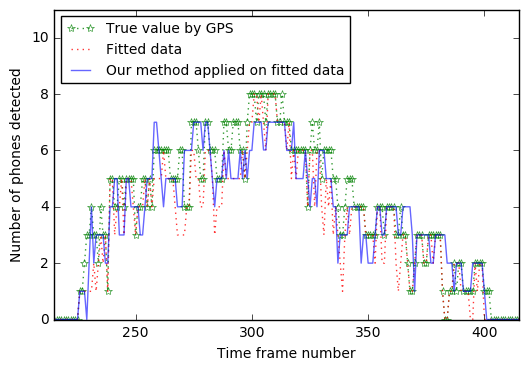

In [761]:
plotLists(lists_upper[4:], labels[4:])

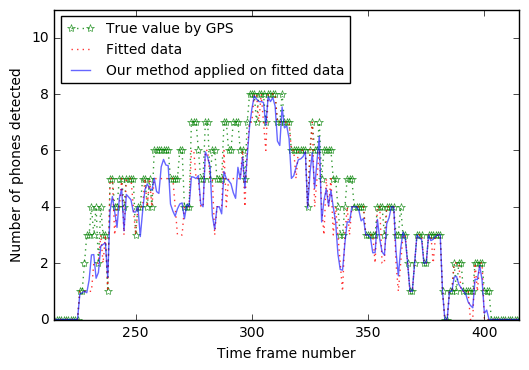

In [57]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

plotLists(lists_upper1[4:], labels[4:])

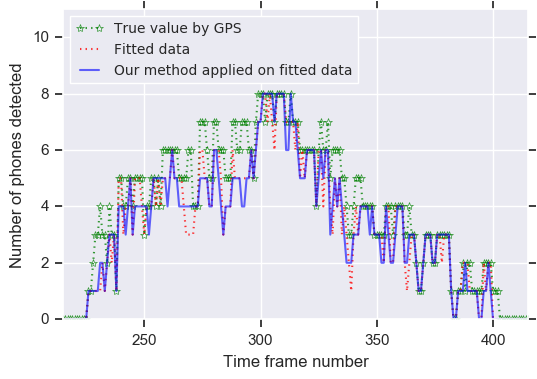

In [263]:
plotLists(lists_upper1[4:], labels[4:])

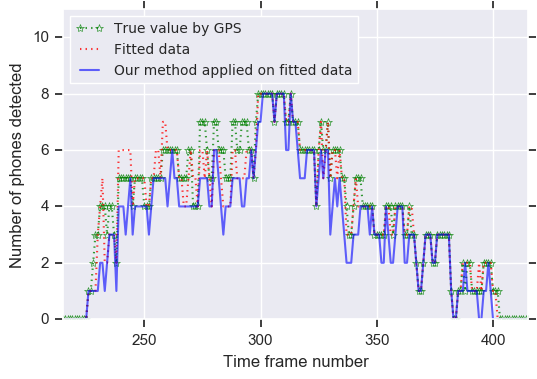

In [270]:
plotLists(lists_upper1[4:], labels[4:])

In [106]:
x_min = 215
x_max = 310
y_min =  20
y_max = 50
belt = 35
cellsize = 1
xmin_cell, xmax_cell, ymin_cell, ymax_cell = x_min/cellsize, x_max/cellsize, y_min/cellsize, y_max/cellsize

In [ ]:
lists_down = run_fing(350, 140, 0, 432, 30)

In [108]:
def plotLists2(lists, labels):
    plt.plot(lists[0], '*', fillstyle="none", color = "green", alpha = 0.8, label = labels[0]  )
    plt.plot(lists[1],  ':', color = "red", alpha = 0.8,  label = labels[1])
    plt.plot(lists[2],  alpha = 0.6, color = "blue", label = labels[2])
    plt.legend(loc=2)
    plt.ylabel('Number of phones in the lower box')
    #plt.ylim(0,9)
    plt.xlim(0, 350)
    plt.show()

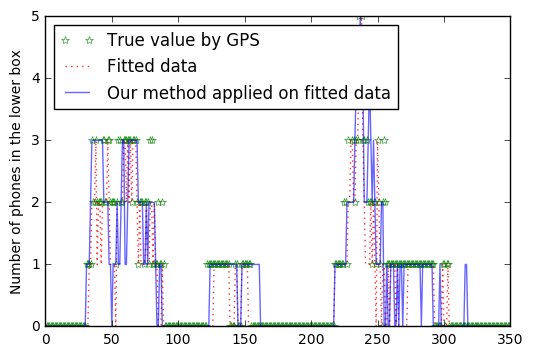

In [109]:
plotLists2(lists_down[4:], labels[4:])

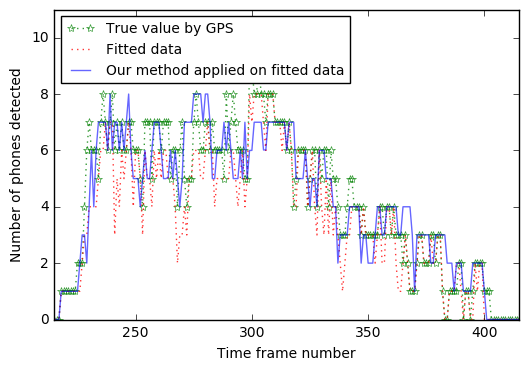

In [111]:
from operator import add
total_lists = []         
for i in range(0,3):
    total_list = list(map (add, lists_down[4:][i] , lists_upper1[4:][i]))
    total_lists.append(total_list)
plotLists(total_lists, labels[4:])

## Arena data: comparison of results

In [234]:
import numpy as np
init_timestamp = 1436067069000 - 5*60*1000
#path_original_positions = "F:/ArenaData/Fingerprinting/"
path_fake_positions = "F:/ArenaData/arena_fits/"

In [235]:
fake_positions = read_fake_positions(path_fake_positions  + "2015-07-05.json")

In [237]:
def run_Arena( width_stadium, length_stadium,  st_window, end_window, stride):    
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    #positions = read_original_positions(path_original_positions + "positions.pkl")    
    #fake_positions = read_fake_positions(path_fake_positions  + "2015-07-05.json")
    for window in range (st_window, end_window):
        print(window)
        #original_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, positions, x_min, x_max, y_min, y_max, belt, 60) 
        fake_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, fake_positions, x_min, x_max, y_min, y_max, belt, 40)        
        method_crowd_count = 1.176* get_all_cells("F:/Arena_sim_data/output/WiFi", xmin_cell, xmax_cell, ymin_cell, ymax_cell, window)      
        #original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        #print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [0,0,0,0,original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists

In [245]:
x_min = 39
x_max = x_min + 15
y_min =  -39
y_max = y_min + 15
cellsize = 1
xmin_cell, xmax_cell, ymin_cell, ymax_cell = x_min/cellsize, x_max/cellsize, y_min/cellsize, y_max/cellsize

In [ ]:
belt = 30#not used
lists_cell15= run_Arena( 240, 180, 0, 40,30)

In [ ]:
x_min = 39
y_min =  -39
lists_grid = []
for i in range (0,5):
    for j in range (0,5):        
        x_min = x_min + i*3
        x_max = x_min + 3
        y_min = y_min + j*3
        y_max = y_min + 3       
        xmin_cell, xmax_cell, ymin_cell, ymax_cell = x_min/cellsize, x_max/cellsize, y_min/cellsize, y_max/cellsize
        lists_grid.append(run_Arena( 240, 180, 0, 40,30))        

In [246]:
def plotListsArena(lists, frames, video):
    labels =  ["z","fitted", "method"]
    #plt.plot(lists[0], '*', fillstyle="none", color = "green", alpha = 0.8, label = labels[0]  )
    plt.plot(lists[5],  ':', color = "red", alpha = 0.9,  label = labels[1])
    plt.plot([x for x in lists[6]],  alpha = 0.9, color = "blue", label = labels[2])
    plt.plot(frames, video, ':', marker = "*", color = "green", label = "video")
    #plt.scatter(frames, video, marker = "*", color = "green")
    plt.legend( fontsize = 10)
    plt.grid(True)
    plt.ylabel('Number of people in a 225 m^2 square')
    plt.xlabel('Time frame')
    #plt.ylim(0,9)
    #plt.xlim(0, 15)
    plt.show()

In [247]:
timepoints = [1436067069000,
              1436067124000,
              1436067159000,
              1436067824000]

In [248]:
frames = [(timepoints[i] - init_timestamp)/40000 + 1 for i in range(0, len(timepoints))]

In [249]:
video = [0.41,  0.37 , 0.47 , 0.25 ]

In [250]:
video = [x*225 for x in video]

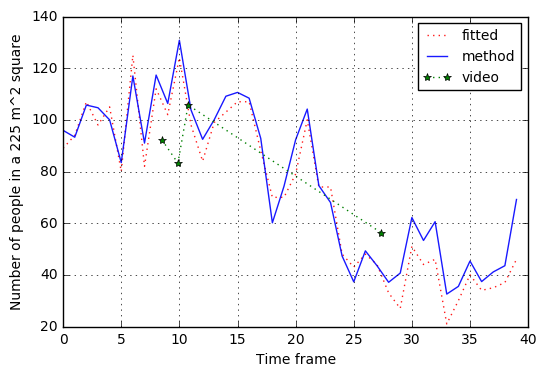

In [244]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
plotListsArena(lists_cell15, frames, video)

In [ ]:
## the above is obtained with window size 40 memory 0

In [ ]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
plotListsArena(lists_cell15, frames, video)

In [857]:
240*180/225

192.0

In [ ]:
plotListsArena(lists_cell15, frames, video)

In [ ]:
from operator import add
import copy
total_lists = copy.deepcopy(lists_grid[0] )
print(total_lists)

In [185]:
for i in range(0,len(lists_grid)-1):
    total_lists[5]=  list(map (add,  total_lists[5], lists_grid[i+1][5] ))
    total_lists[6]=  list(map (add,  total_lists[6], lists_grid[i+1][6] ))

In [ ]:
plotListsArena(total_lists, frames, video)

In [221]:
video = [0.41,  0.37 , 0.47 , 0.25 ]
video = [x*9 for x in video]

In [ ]:
for listt in lists_grid:
    plotListsArena(listt, frames, video)
    
    

In [ ]:
belt = 30#not used
lists_cell15_1= run_Arena( 240, 180, 0, 40,30)

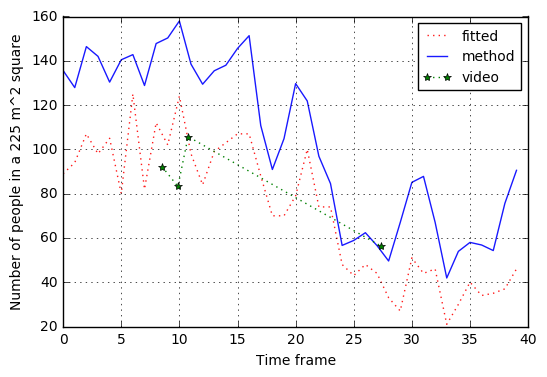

In [48]:
plotListsArena(lists_cell15_1, frames, video)

In [ ]:
##the above is obtaines with window size 60